In [ ]:
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.1 MB/s eta 0:00:00


In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=b2834f897c5c011b27cc628cbe94151efa1733811e8560ac53cde563200e9159
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils


In [ ]:
pip install numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requi

In [ ]:
import import_ipynb
import text_utils
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
import pickle
import os
import requests
import zipfile
from tqdm import tqdm
from huggingface_hub import HfApi, Repository, hf_hub_download
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from gensim.models import KeyedVectors
import gensim.downloader as api

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from huggingface_hub import Repository, login
import os
import pickle
import torch

def push_to_hub(model, embeddings_index, repo_name="ali9999/fake-job-detection-model", hf_token=None):
    """
    Push the trained model and GloVe embeddings index to Hugging Face Hub.
    """
    if hf_token:
        login(token=hf_token)  # Optional: for explicit login

    model_path = "fraud_model.pt"
    embeddings_path = "embeddings_index.pkl"
    repo_dir = "hf_model_repo"

    # Save locally
    torch.save(model.state_dict(), model_path)
    with open(embeddings_path, "wb") as f:
        pickle.dump(embeddings_index, f)

    # Clone or initialize repo
    if os.path.exists(repo_dir):
        os.system(f"rm -rf {repo_dir}")  # optional: clean before re-cloning

    repo = Repository(local_dir=repo_dir, clone_from=repo_name)

    # Move files to repo directory
    os.replace(model_path, os.path.join(repo_dir, model_path))
    os.replace(embeddings_path, os.path.join(repo_dir, embeddings_path))

    os.system('git config --global user.email "sayyidaliahmed1@gmail.com"')
    os.system('git config --global user.name "Ali Ahmed"')

    # Push
    repo.git_add()
    repo.git_commit("Add model and embeddings index")
    repo.git_push()


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
class Embedder(nn.Module):
    def __init__(self, input_dim=300, embed_dim=16, num_classes=2):
        super(Embedder, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 32),
            nn.ReLU(),
            nn.Linear(32, embed_dim),
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        z = self.embedding(x)
        logits = self.classifier(z)
        return z, logits


In [ ]:
def custom_loss(embeddings, logits, labels, k=3, alpha=0.6, margin=1.0, beta=0.9):
    # Balanced cross-entropy
    class_counts = torch.bincount(labels)
    weights = 1.0 / (class_counts.float() + 1e-8)
    weights = weights.to(logits.device)
    classification_loss = nn.functional.cross_entropy(logits, labels, weight=weights)

    embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
    contrastive_loss = 0.0
    loss_count = 0

    for cls in torch.unique(labels):
        same_mask = labels == cls
        other_mask = labels != cls
        cluster = embeddings[same_mask]
        other = embeddings[other_mask]

        if cluster.size(0) < k + 1 or other.size(0) < k:
            continue

        # Dynamically computed centroid (differentiable)
        centroid = cluster.mean(dim=0, keepdim=True)

        # Pull loss (within class)
        dists_within = torch.norm(cluster - centroid, dim=1)
        farthest = cluster[torch.topk(dists_within, k).indices]
        pull_loss = torch.sum((farthest - centroid) ** 2)

        # Push loss (between class)
        dists_other = torch.norm(other - centroid, dim=1)
        topk_closest = other[torch.topk(-dists_other, k).indices]
        push_dists = torch.norm(topk_closest - centroid.squeeze(), dim=1)
        push_loss = torch.sum(torch.clamp(margin - push_dists, min=0) ** 2)

        # Balanced contrastive loss
        contrastive_loss += (1 - alpha) * pull_loss + alpha * push_loss
        loss_count += 1

    contrastive_loss = contrastive_loss / max(loss_count, 1)
    return beta * classification_loss + (1 - beta) * contrastive_loss


In [ ]:
def document_vector(text, word2vec_model, dim=300):
    """Compute the average Word2Vec vector for a document."""
    words = text.split()  # Simple tokenization; adjust based on your preprocessing
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    if len(vectors) == 0:
        return np.zeros(dim)  # Return zero vector if no valid words
    return np.mean(vectors, axis=0)

In [ ]:
import matplotlib.pyplot as plt

def plot_centroids(embeddings, labels, epoch):
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()

    # Compute centroids for each class
    centroids = []
    for cls in torch.unique(labels):
        mask = labels == cls
        class_embs = emb_np[mask.cpu().numpy()]
        centroid = class_embs.mean(axis=0)
        centroids.append((cls.item(), centroid))

    # Plot first 2 dims + centroids
    plt.figure(figsize=(6, 6))
    plt.scatter(emb_np[:, 0], emb_np[:, 1], c=labels_np, cmap='coolwarm', alpha=0.5, s=10)
    for cls, centroid in centroids:
        plt.scatter(centroid[0], centroid[1], label=f"Centroid Class {cls}", s=120, marker='X', edgecolors='black')
    plt.title(f"Class Centroids - Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"centroid_plot_epoch_{epoch}.png")
    plt.close()

def train():
    # Load pre-cleaned dataset
    df = pd.read_csv("cleaned_dataset.csv")
    X_texts = df['text'].tolist()
    y = df['fraudulent'].values

    # Load GloVe vectors
    #glove_txt_path = text_utils.download_glove(destination_folder='glove', dim=300)
    #embeddings_index = text_utils.load_glove_embeddings(glove_txt_path)
        # Load or download Word2Vec model

    model_name = "word2vec-google-news-300"
    cache_path = os.path.join(os.path.expanduser("~"), "gensim-data", model_name, f"{model_name}.gz")
    print("Checking for cached Word2Vec model...")
    try:
        # Check if model is already cached
        if os.path.exists(cache_path):
            print(f"Loading cached Word2Vec model from {cache_path}...")
            word2vec_model = KeyedVectors.load_word2vec_format(cache_path, binary=True)
            print("Cached Word2Vec model loaded.")
        else:
            print(f"Downloading {model_name}...")
            word2vec_model = api.load(model_name)
            print("Word2Vec model downloaded and loaded.")
    except Exception as e:
        print(f"Error loading Word2Vec model: {e}")
        exit(1)

    #X_vectors = np.array([text_utils.document_vector(text, embeddings_index) for text in X_texts])

    X_vectors = np.array([document_vector(text, word2vec_model, dim=300) for text in X_texts])

    # Handle class imbalance
    adasyn = ADASYN(sampling_strategy=0.4, random_state=42, n_neighbors=5)
    X_res, y_res = adasyn.fit_resample(X_vectors, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Initialize model
    model = Embedder()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()

    # Training loop
    for epoch in range(3000):
        optimizer.zero_grad()
        embeddings, logits = model(X_train_tensor)
        loss = custom_loss(embeddings, logits, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Plot centroids every 500 epochs
        if (epoch + 1) % 500 == 0:
            print(f"Plotting centroids at epoch {epoch+1}")
            plot_centroids(embeddings, y_train_tensor, epoch + 1)

    # Save model and embeddings
    #torch.save(model.state_dict(), "fraud_model.pt")
    #with open("embeddings_index.pkl", "wb") as f:
        #pickle.dump(embeddings_index, f)

    #torch.save(model.state_dict(), "fraud_model.pt")
    #with open("word2vec_model.pkl", "wb") as f:
        #word2vec_model.save(f)


    print("Training done and saved locally.")
    #return model, X_test_tensor, y_test_tensor, embeddings_index

    return model, X_test_tensor, y_test_tensor, word2vec_model


In [ ]:
if __name__ == "__main__":
    model, X_test_tensor, y_test_np, embeddings_index = train()
    model.eval()
    with torch.no_grad():
        emb_test, logits_test = model(X_test_tensor)

    # Predictions
    preds = torch.argmax(logits_test, dim=1).numpy()

    #push_to_hub(model, embeddings_index, repo_name="ali9999/fake-job-detection-model")
    #print("Pushed model and embeddings to Hugging Face Hub.")


Checking for cached Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model downloaded and loaded.
Epoch 10, Loss: 0.8007
Epoch 20, Loss: 0.7927
Epoch 30, Loss: 0.7207
Epoch 40, Loss: 0.6599
Epoch 50, Loss: 0.5796
Epoch 60, Loss: 0.5108
Epoch 70, Loss: 0.4684
Epoch 80, Loss: 0.4141
Epoch 90, Loss: 0.4075
Epoch 100, Loss: 0.4164
Epoch 110, Loss: 0.3679
Epoch 120, Loss: 0.3262
Epoch 130, Loss: 0.2978
Epoch 140, Loss: 0.2711
Epoch 150, Loss: 0.2579
Epoch 160, Loss: 0.7464
Epoch 170, Loss: 0.3541
Epoch 180, Loss: 0.2494
Epoch 190, Loss: 0.2046
Epoch 200, Loss: 0.1751
Epoch 210, Loss: 0.1747
Epoch 220, Loss: 0.1516
Epoch 230, Loss: 0.1339
Epoch 240, Loss: 0.6497
Epoch 250, Loss: 0.2036
Epoch 260, Loss: 0.1628
Epoch 270, Loss: 0.1402
Epoch 280, Loss: 0.1286
Epoch 290, Loss: 0.1189
Epoch 300, Loss: 0.1130
Epoch 310, Loss: 0.1117
Epoch 320, Loss: 1.8648
Epoch 330, Loss: 0.4921
Epoch 340, Loss: 0.3506
Epoch 350, Loss: 0.2421
Epoch 


Accuracy: 0.986, F1 Score: 0.977

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3403
           1       0.96      1.00      0.98      1386

    accuracy                           0.99      4789
   macro avg       0.98      0.99      0.98      4789
weighted avg       0.99      0.99      0.99      4789


Silhouette Score: 0.387
Adjusted Rand Index: 0.944


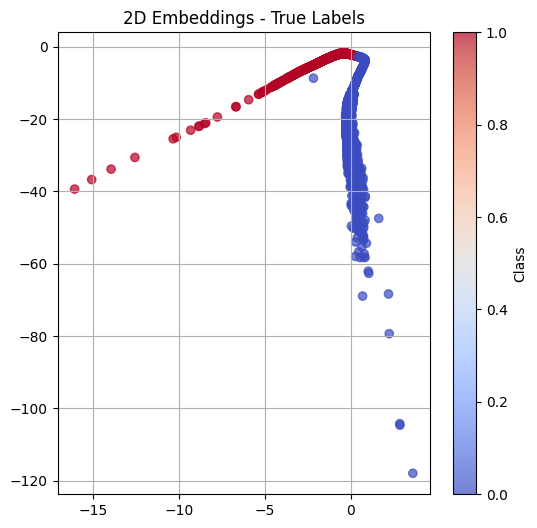


Normalized Mutual Information: 0.891
Homogeneity Score: 0.898
Completeness Score: 0.884
V-Measure: 0.891
Calinski-Harabasz Score: 2297.906
Davies-Bouldin Score: 0.772


In [ ]:
acc = accuracy_score(y_test_np, preds)
f1 = f1_score(y_test_np, preds)
print(f"\nAccuracy: {acc:.3f}, F1 Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test_np, preds))
# Clustering metrics
emb_np = emb_test.numpy()
sil_score = silhouette_score(emb_np, y_test_np)
ari = adjusted_rand_score(y_test_np, preds)
print(f"\nSilhouette Score: {sil_score:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("2D Embeddings - True Labels")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()

# These use true labels vs predicted clusters
nmi = normalized_mutual_info_score(y_test_np, preds)
hom = homogeneity_score(y_test_np, preds)
comp = completeness_score(y_test_np, preds)
v_score = v_measure_score(y_test_np, preds)

# These use embeddings only
ch_score = calinski_harabasz_score(emb_np, y_test_np)
db_score = davies_bouldin_score(emb_np, y_test_np)

print(f"\nNormalized Mutual Information: {nmi:.3f}")
print(f"Homogeneity Score: {hom:.3f}")
print(f"Completeness Score: {comp:.3f}")
print(f"V-Measure: {v_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

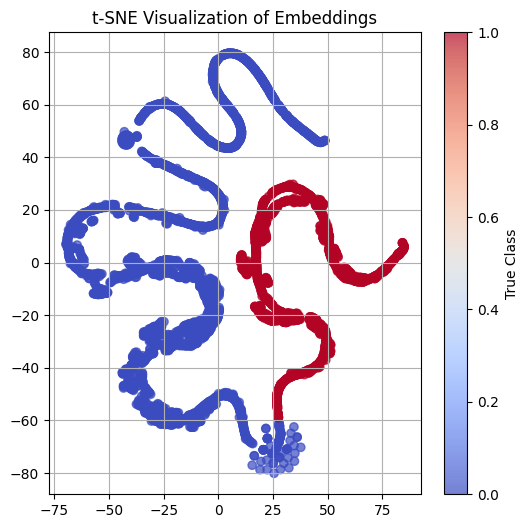

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(emb_np)

plt.figure(figsize=(6, 6))
plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.colorbar(label="True Class")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



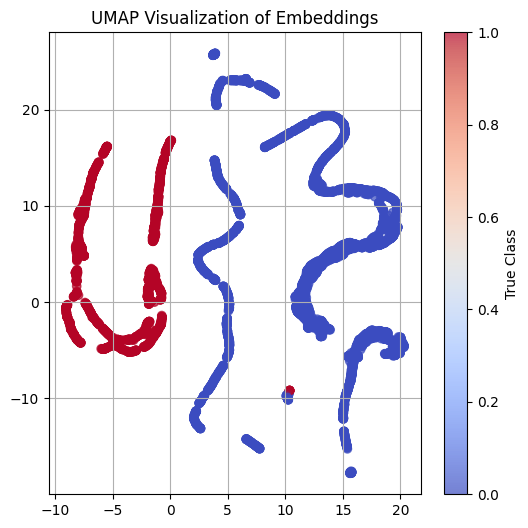

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
emb_umap = reducer.fit_transform(emb_np)

plt.figure(figsize=(6, 6))
plt.scatter(emb_umap[:, 0], emb_umap[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("UMAP Visualization of Embeddings")
plt.colorbar(label="True Class")
plt.grid(True)
plt.show()


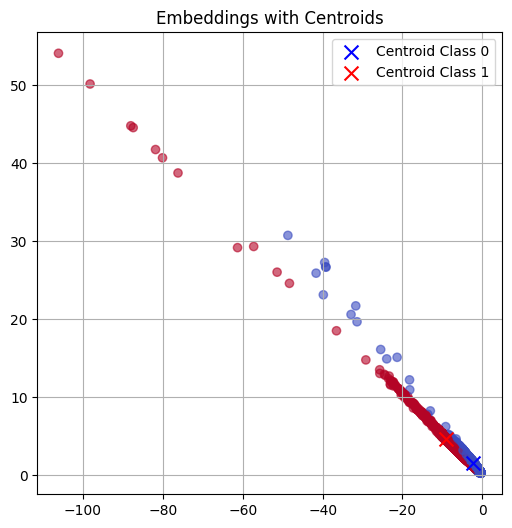

In [ ]:
import numpy as np

class0_mask = preds == 0
class1_mask = preds == 1

centroid_0 = emb_np[class0_mask].mean(axis=0)
centroid_1 = emb_np[class1_mask].mean(axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(emb_np[:, 0], emb_np[:, 1], c=preds, cmap='coolwarm', alpha=0.6)
plt.scatter(*centroid_0[:2], c='blue', s=100, marker='x', label='Centroid Class 0')
plt.scatter(*centroid_1[:2], c='red', s=100, marker='x', label='Centroid Class 1')
plt.title("Embeddings with Centroids")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px
fig = px.scatter(x=emb_tsne[:, 0], y=emb_tsne[:, 1], color=preds.astype(str), title="Interactive t-SNE")
fig.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# ========== Embedder Model ==========
class Embedder(nn.Module):
    def __init__(self, input_dim=20, embed_dim=16, num_classes=3):
        super(Embedder, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
        )
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        z = self.embedding(x)
        logits = self.classifier(z)
        return z, logits

# ========== Custom Loss ==========
def custom_loss(embeddings, logits, labels, k=3, alpha=1.0, margin=1.0, beta=0.7):
    class_counts = torch.bincount(labels)
    weights = 1.0 / (class_counts.float() + 1e-8)
    weights = weights.to(logits.device)
    classification_loss = nn.functional.cross_entropy(logits, labels, weight=weights)

    embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
    contrastive_loss = 0.0
    loss_count = 0

    for cls in torch.unique(labels):
        same_mask = labels == cls
        other_mask = labels != cls
        cluster = embeddings[same_mask]
        other = embeddings[other_mask]

        if cluster.size(0) < k + 1 or other.size(0) < k:
            continue

        centroid = cluster.mean(dim=0, keepdim=True)
        dists_within = torch.norm(cluster - centroid, dim=1)
        farthest = cluster[torch.topk(dists_within, k).indices]
        pull_loss = torch.sum((farthest - centroid) ** 2)

        dists_other = torch.norm(other - centroid, dim=1)
        topk_closest = other[torch.topk(-dists_other, k).indices]
        push_dists = torch.norm(topk_closest - centroid.squeeze(), dim=1)
        push_loss = torch.sum(torch.clamp(margin - push_dists, min=0) ** 2)

        contrastive_loss += (1 - alpha) * pull_loss + alpha * push_loss
        loss_count += 1

    contrastive_loss = contrastive_loss / max(loss_count, 1)
    return beta * classification_loss + (1 - beta) * contrastive_loss

# ========== Visualizations ==========
def plot_tsne(embeddings, labels, name="tsne_plot.png"):
    n_samples = embeddings.shape[0]
    perplexity = min(30, max(5, n_samples // 3))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    emb_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    plt.figure(figsize=(6, 6))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.6)
    plt.title("t-SNE of Embeddings")
    plt.grid(True)
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.close()

def plot_centroids(embeddings, labels, epoch, save_dir="centroid_plots"):
    os.makedirs(save_dir, exist_ok=True)
    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.cpu().numpy()
    centroids = []
    for cls in np.unique(labels_np):
        mask = labels_np == cls
        centroid = emb_np[mask].mean(axis=0)
        centroids.append((cls, centroid))

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_np[:, 0], emb_np[:, 1], c=labels_np, cmap='tab10', alpha=0.5)
    for cls, c in centroids:
        plt.scatter(c[0], c[1], s=100, marker='X', label=f"Centroid {cls}", edgecolors='black')
    plt.title(f"Centroids at Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_dir}/centroids_epoch_{epoch}.png", dpi=300, bbox_inches='tight')
    plt.close()

# ========== Training ==========
def train_on_dataset(X, y, dataset_name, num_classes):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    model = Embedder(input_dim=X.shape[1], num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        embeddings, logits = model(X_train_tensor)
        loss = custom_loss(embeddings, logits, y_train_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"[{dataset_name}] Epoch {epoch} Loss: {loss.item():.4f}")
            with torch.no_grad():
                model.eval()
                emb_test, logits_test = model(X_test_tensor)
                pred_test = torch.argmax(logits_test, dim=1)
                acc = accuracy_score(y_test_tensor.cpu(), pred_test.cpu())
                print(f"[{dataset_name}] Test Accuracy: {acc:.4f}")
                plot_tsne(emb_test, y_test_tensor, name=f"visuals/{dataset_name}_tsne_epoch_{epoch}.png")
                plot_centroids(emb_test, y_test_tensor, epoch, save_dir=f"visuals/{dataset_name}_centroids")

# ========== Run on Real Datasets ==========
if __name__ == "__main__":
    os.makedirs("visuals", exist_ok=True)

    datasets = {
        "iris": (load_iris(return_X_y=True), 3),
        "wine": (load_wine(return_X_y=True), 3),
        "digits": (load_digits(return_X_y=True), 10),
    }

    for name, ((X, y), num_classes) in datasets.items():
        print(f"\n--- Training on {name} dataset ---")
        train_on_dataset(X, y, dataset_name=name, num_classes=num_classes)


--- Training on iris dataset ---
[iris] Epoch 0 Loss: 1.1753
[iris] Test Accuracy: 0.6667
[iris] Epoch 1 Loss: 0.9440
[iris] Test Accuracy: 0.6667
[iris] Epoch 2 Loss: 0.7400
[iris] Test Accuracy: 0.6667
[iris] Epoch 3 Loss: 0.6676
[iris] Test Accuracy: 0.6667
[iris] Epoch 4 Loss: 0.5775
[iris] Test Accuracy: 0.6667
[iris] Epoch 5 Loss: 0.5099
[iris] Test Accuracy: 0.7000
[iris] Epoch 6 Loss: 0.4592
[iris] Test Accuracy: 0.7000
[iris] Epoch 7 Loss: 0.4218
[iris] Test Accuracy: 0.7333
[iris] Epoch 8 Loss: 0.3910
[iris] Test Accuracy: 0.7667
[iris] Epoch 9 Loss: 0.3640
[iris] Test Accuracy: 0.7667

--- Training on wine dataset ---
[wine] Epoch 0 Loss: 1.1890
[wine] Test Accuracy: 0.3333
[wine] Epoch 1 Loss: 0.8237
[wine] Test Accuracy: 0.6111
[wine] Epoch 2 Loss: 0.7205
[wine] Test Accuracy: 0.8889
[wine] Epoch 3 Loss: 0.6146
[wine] Test Accuracy: 0.9722
[wine] Epoch 4 Loss: 0.5024
[wine] Test Accuracy: 0.9722
[wine] Epoch 5 Loss: 0.3777
[wine] Test Accuracy: 0.9722
[wine] Epoch 6 Loss: